In [11]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.utils.class_weight import compute_class_weight

In [12]:
df = pd.read_csv('dataset.csv')  # Ajusta la ruta

print("🔍 Primer vistazo al dataset:")
print(df.head())
print(f"\n📊 Dimensiones: {df.shape}")
print(f"\n🎯 Distribución del target:")
print(df['target_variable'].value_counts())

# Información general
print("\n📋 Info del dataset:")
print(df.info())
print("\n📈 Estadísticas descriptivas:")
print(df.describe())

🔍 Primer vistazo al dataset:
   id  product_A_sold_in_the_past  product_B_sold_in_the_past  \
0   1                    -0.25992                    -0.34794   
1   2                    -0.25992                    -0.28599   
2   3                    -0.25992                    -0.18998   
3   4                     0.65945                     3.35306   
4   5                    -0.25992                    -0.24623   

   product_A_recommended  product_A  product_C  product_D  cust_hitrate  \
0                -0.1097    -0.0891   -0.02372   -0.04247       0.12643   
1                -0.1097    -0.0891   -0.02372   -0.04247       0.42465   
2                -0.1097    -0.0891   -0.02372   -0.04247       0.72559   
3                -0.1097    -0.0891   -0.02372   -0.04247       1.55091   
4                -0.1097    -0.0891   -0.02372   -0.04247      -0.50193   

   cust_interactions  cust_contracts  opp_month  opp_old  competitor_Z  \
0            0.30731        -0.34997   -1.41464 -0.2818

📚 Datos de entrenamiento: (28719, 15)
🧪 Datos de test: (7180, 15)

🔎 Ejecutando GridSearch para optimizar F1...
Fitting 5 folds for each of 54 candidates, totalling 270 fits

🏆 Mejor combinación de hiperparámetros encontrada:
{'class_weight': {np.int64(0): np.float64(0.944269086604853), np.int64(1): np.float64(1.062722024866785)}, 'max_depth': 22, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 400}

📊 MÉTRICAS DEL MODELO OPTIMIZADO:
              precision    recall  f1-score   support

           0       0.86      0.83      0.85      3802
           1       0.82      0.85      0.83      3378

    accuracy                           0.84      7180
   macro avg       0.84      0.84      0.84      7180
weighted avg       0.84      0.84      0.84      7180



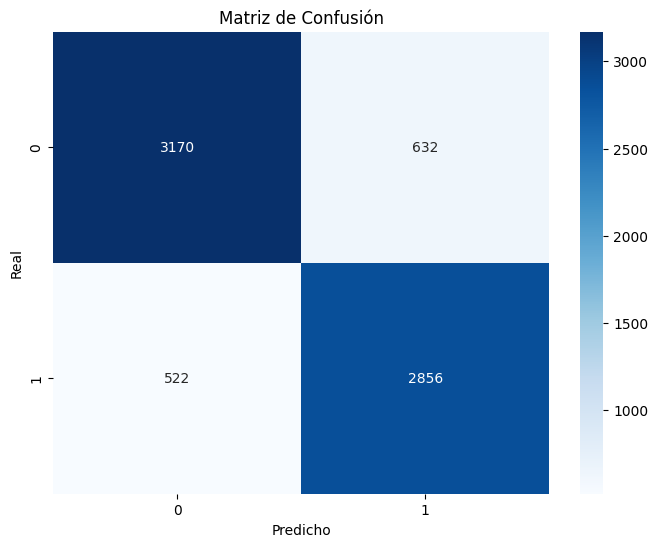


🎯 IMPORTANCIA DE LAS VARIABLES:
                       feature  importance
6                 cust_hitrate    0.311814
7            cust_interactions    0.183246
9                    opp_month    0.130209
1   product_B_sold_in_the_past    0.121581
0   product_A_sold_in_the_past    0.060771
8               cust_contracts    0.055477
10                     opp_old    0.040372
13                competitor_Y    0.022550
2        product_A_recommended    0.021027
11                competitor_Z    0.019294
14              cust_in_iberia    0.018916
3                    product_A    0.009415
5                    product_D    0.002818
12                competitor_X    0.001502
4                    product_C    0.001008


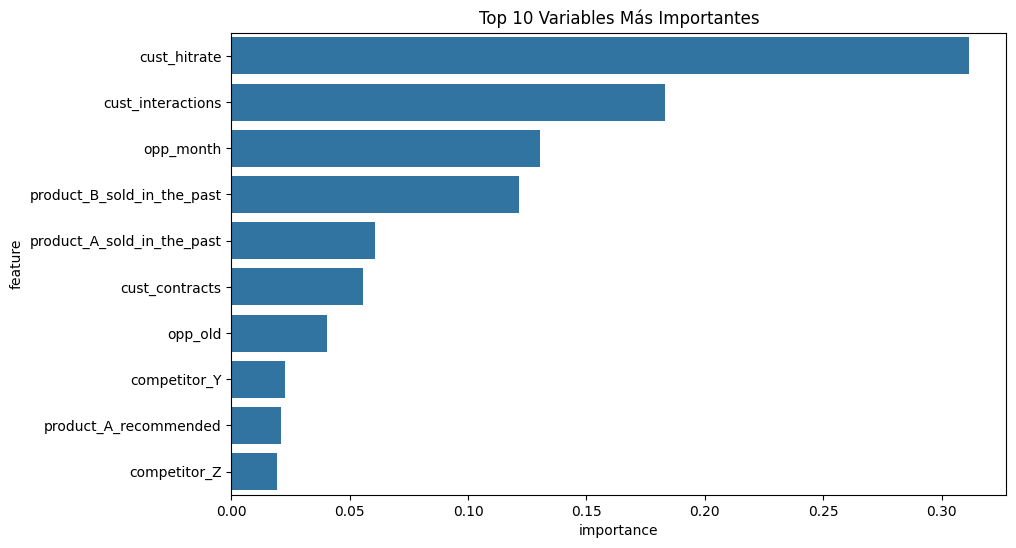

In [13]:
def entrenar_modelo_clasificacion(df):
    # Separar features y target
    X = df.drop('target_variable', axis=1)
    y = df['target_variable']
    
    # Si quieres excluir el ID también
    if 'id' in X.columns:
        X = X.drop('id', axis=1)
    
    # Dividir en train/test
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    
    print(f"📚 Datos de entrenamiento: {X_train.shape}")
    print(f"🧪 Datos de test: {X_test.shape}")
    
    # Pesos automáticos por desbalance
    clases = np.unique(y_train)
    pesos = compute_class_weight("balanced", classes=clases, y=y_train)
    class_weights = {clase: peso for clase, peso in zip(clases, pesos)}

    # Definir el modelo base
    rf = RandomForestClassifier(random_state=42, n_jobs=-1)

    # GridSearch — parámetros optimizados
    param_grid = {
        "n_estimators": [200, 400],
        "max_depth": [14, 18, 22],
        "min_samples_split": [2, 4, 6],
        "min_samples_leaf": [1, 2, 3],
        "class_weight": [class_weights]
    }

    print("\n🔎 Ejecutando GridSearch para optimizar F1...")

    grid = GridSearchCV(
        estimator=rf,
        param_grid=param_grid,
        scoring="f1",
        cv=5,
        n_jobs=-1,
        verbose=1
    )

    grid.fit(X_train, y_train)

    print("\n🏆 Mejor combinación de hiperparámetros encontrada:")
    print(grid.best_params_)

    best_model = grid.best_estimator_

    # Predicción final
    y_pred = best_model.predict(X_test)

    print("\n📊 MÉTRICAS DEL MODELO OPTIMIZADO:")
    print(classification_report(y_test, y_pred))

    # Matriz de confusión
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title("Matriz de Confusión")
    plt.ylabel("Real")
    plt.xlabel("Predicho")
    plt.show()

    # Importancia de características
    feature_importance = pd.DataFrame({
        "feature": X.columns,
        "importance": best_model.feature_importances_
    }).sort_values("importance", ascending=False)

    print("\n🎯 IMPORTANCIA DE LAS VARIABLES:")
    print(feature_importance)

    plt.figure(figsize=(10, 6))
    sns.barplot(data=feature_importance.head(10), x="importance", y="feature")
    plt.title("Top 10 Variables Más Importantes")
    plt.show()

    return best_model, X_train, X_test, y_train, y_test

# Ejecutar el modelo
modelo, X_train, X_test, y_train, y_test = entrenar_modelo_clasificacion(df)

In [14]:
def predecir_nuevos_clientes(model, nuevos_datos):
    """
    nuevos_datos: DataFrame con las mismas columnas que el dataset original
    """
    # Excluir target_variable si existe
    if 'target_variable' in nuevos_datos.columns:
        nuevos_datos = nuevos_datos.drop('target_variable', axis=1)
    
    if 'id' in nuevos_datos.columns:
        nuevos_datos = nuevos_datos.drop('id', axis=1)
    
    predicciones = model.predict(nuevos_datos)
    probabilidades = model.predict_proba(nuevos_datos)
    
    resultados = pd.DataFrame({
        'prediccion': predicciones,
        'probabilidad_clase_1': probabilidades[:, 1],
        'probabilidad_clase_0': probabilidades[:, 0]
    })
    
    return resultados


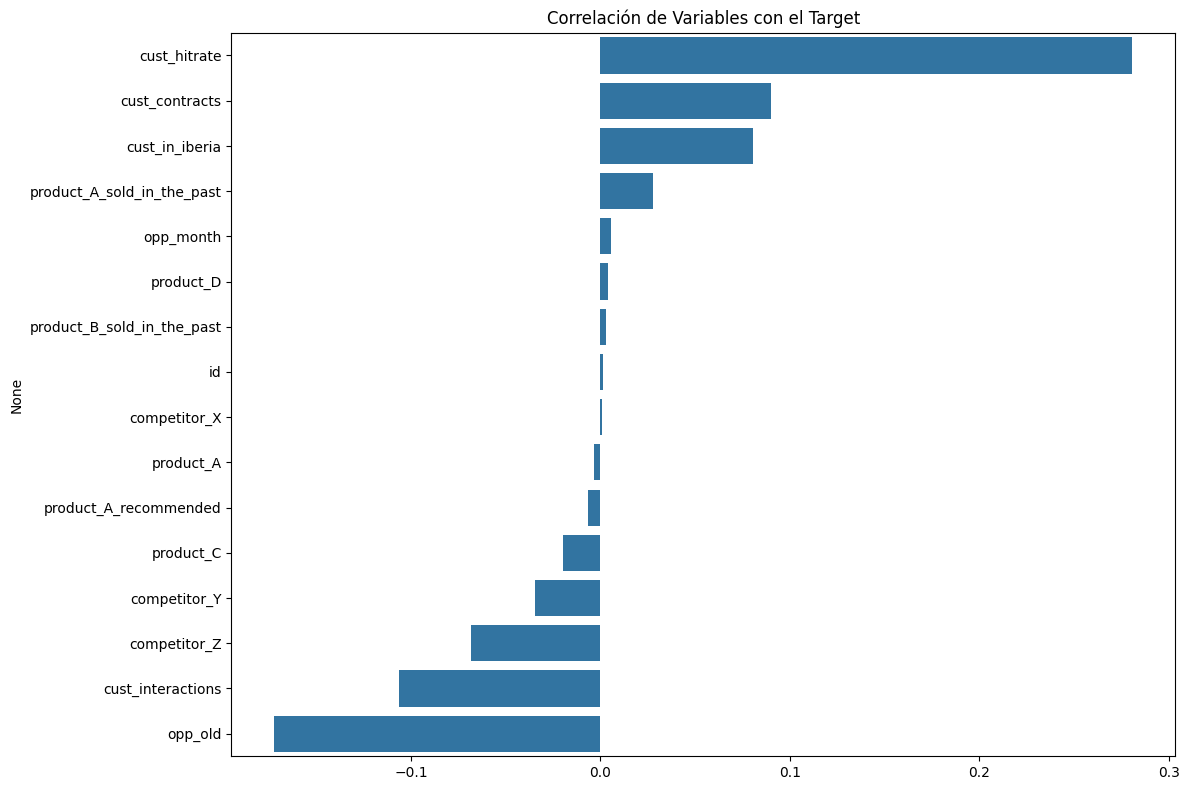

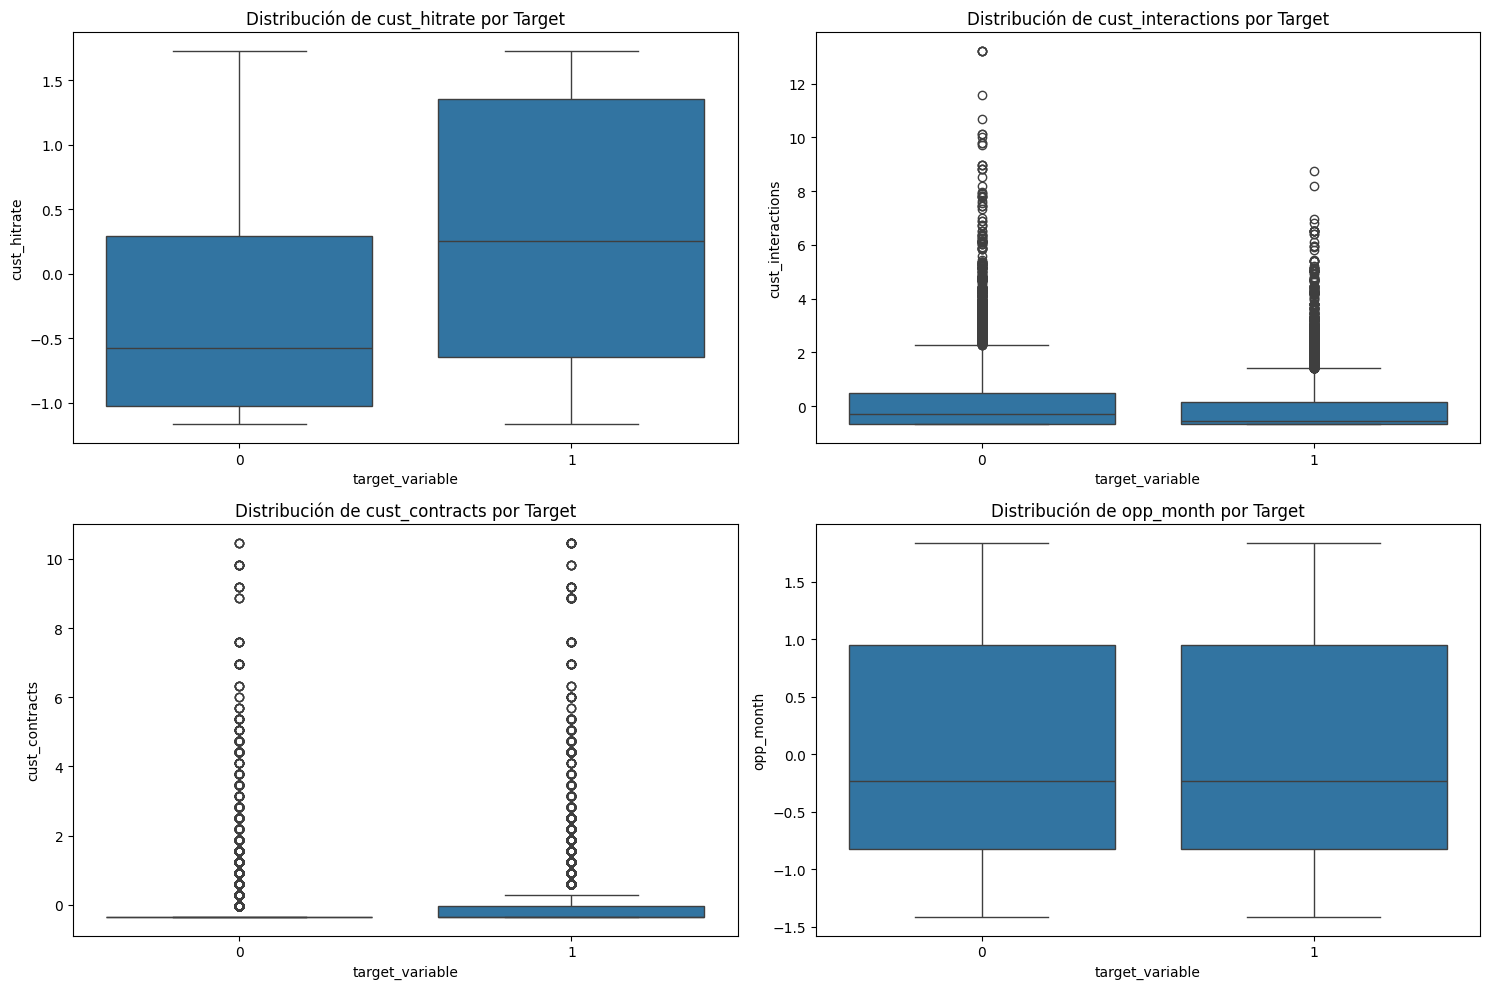

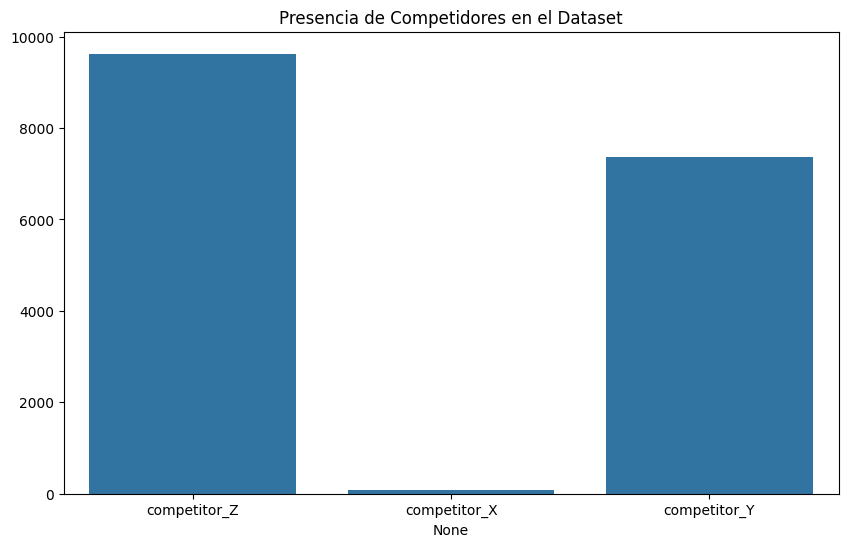

In [15]:
def analisis_completo_dataset(df):
    # 1. Correlación con el target
    plt.figure(figsize=(12, 8))
    correlation_with_target = df.corr()['target_variable'].sort_values(ascending=False)
    correlation_with_target.drop('target_variable', inplace=True)
    
    sns.barplot(x=correlation_with_target.values, y=correlation_with_target.index)
    plt.title('Correlación de Variables con el Target')
    plt.tight_layout()
    plt.show()
    
    # 2. Distribución de variables importantes
    variables_importantes = ['cust_hitrate', 'cust_interactions', 'cust_contracts', 'opp_month']
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    axes = axes.ravel()
    
    for i, var in enumerate(variables_importantes):
        if var in df.columns:
            sns.boxplot(data=df, x='target_variable', y=var, ax=axes[i])
            axes[i].set_title(f'Distribución de {var} por Target')
    
    plt.tight_layout()
    plt.show()
    
    # 3. Análisis de competidores
    competidores = ['competitor_Z', 'competitor_X', 'competitor_Y']
    if all(col in df.columns for col in competidores):
        plt.figure(figsize=(10, 6))
        comp_sum = df[competidores].sum()
        sns.barplot(x=comp_sum.index, y=comp_sum.values)
        plt.title('Presencia de Competidores en el Dataset')
        plt.show()

# Ejecutar análisis completo
analisis_completo_dataset(df)